In [2]:
# Importing cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from numerize import numerize as n

-----------------------------

# Physical Models of Living Systems

#### *Rafaele Gaudio 2057974*

-----------------------------

## Week 6: - Deadline 8 Dicember 

Consider a Consumer Resource Model with supply rate $s(c)=wc(1-c/K)$ and resource concentration $r(c)=c$ is linear for $S=5$ species and $R=5$ resources. Assign the metabolic strategies from a Uniform Distribution between $[0,0.2]$, while set all other parameters to 1 and choose the death rate small enough as you prefer.

1) Perform the simulations on the full CRM and compare the stationary solution you find numerically with those obtained analitically.

2) Set $w=10$ and do the simulations for the quasi stationarity approximation (find first $c^*$ and then simulating $n(t,c^*)$) and compare it with the simulations of the full CRM (keeping fix the metabolic strategies in the two cases for a given realization). Do several (e.g >20) realization of the dynamics to obtain a ststistics of the species poulation stationary state in the two cases, represent each population through a Box-Whisker Plot both for the full CRM and the GLV and compare the two.

3) Does the quasi stationary approximation work if $w=0.1$? Why?


-----------------------------

In [3]:
# Functions  cell

# Models functions ############################################################

def CRM(y, t, v, alpha, w, K, d, S):

  n = y[:S]
  c = y[S:]
  growth_rate = np.sum(v * alpha * c, axis=1)
  dn = n * (growth_rate - d)
  dc = w * c * (1 - c / K) - np.sum(n[:, np.newaxis] * alpha * c, axis=0)

  return np.concatenate([dn, dc])


def CRM_QSA(y, t, v, alpha, w, K, d, S):

  n = y[:S]
  c = y[S:]
  c = K/w * (w - np.sum(n[:, np.newaxis] * alpha, axis=0))
  growth_rate = np.sum(v * alpha * c, axis=1)
  dn = n * (growth_rate - d)

  return np.concatenate([dn, c])


# Stationary analisys functions ################################################

def growth_stationary(v,alpha,c):
    growth_rate = np.sum(v * alpha * c, axis=1)
    return growth_rate

def c_star(w,K,alpha,n):
    c = K/w * (w - np.sum(n[:, np.newaxis] * alpha, axis=0))
    return c


# Simulation plotter function ##################################################

def sim_plotter(t, c, N, S, c_xzoom, c_yzoom, n_xzoom, n_yzoom, sol_type):
    
    # plot resources
    fig1, ax1= plt.subplots(1,2,figsize=(18,5))
    fig1.suptitle("{} Solutions - Resources".format(sol_type),fontsize=14)
    ax1[0].set(xlabel="t [A.U.]", ylabel="$c_i(t)$", title="Full dynamics")
    ax1[0].grid(alpha=0.6)
    ax1[1].set(xlabel="t [A.U.]", ylabel="$c_i(t)$", title="Zoom")
    ax1[1].set_xlim(c_xzoom[0],c_xzoom[1])
    ax1[1].set_ylim(c_yzoom[0],c_yzoom[1])
    ax1[1].grid(alpha=0.6)
    for i in range(S):
        ax1[0].plot(t,c[:,i],label="i={}".format(i+1))
        ax1[1].plot(t,c[:,i],label="i={}".format(i+1))
    ax1[0].legend()
    ax1[1].legend()

    # Plot poulations
    fig2, ax2= plt.subplots(1,2,figsize=(18,5))
    fig2.suptitle("{} Solutions - Populations".format(sol_type),fontsize=14)
    ax2[0].set(xlabel="t [A.U.]", ylabel="$n_i(t)$", title="Full dynamics")
    ax2[0].grid(alpha=0.6)
    ax2[1].set(xlabel="t [A.U.]", ylabel="$n_i(t)$", title="Zoom")
    ax2[1].set_xlim(n_xzoom[0],n_xzoom[1])
    ax2[1].set_ylim(n_yzoom[0],n_yzoom[1])
    ax2[1].grid(alpha=0.6)

    for i in range(S):
        ax2[0].plot(t,N[:,i],label="$\sigma$={}".format(i+1))
        ax2[1].plot(t,N[:,i],label="$\sigma$={}".format(i+1))
    ax2[0].legend()
    ax2[1].legend()

    return()  


## 1. Consumer Resource Model 

The Consumer Resource Model (CRM) for $\sigma = 1,...,S$ species and $i=1,...,R$ resources is defined as:

$$
\begin{cases}
\dot{n}_\sigma=n_\sigma\left( \sum^R_{i=1}v_i \alpha_{\sigma i}r_i(c_i)-\delta_\sigma\right) \qquad \sigma=1,...,S \\
\dot{c}_i=s_i-\sum_{\sigma=1}^S n_\sigma \alpha_{\sigma i}r_i(c_i) \qquad \qquad i=1,...,R

\end{cases}
$$

$s_i$ is the supply rate (i.e. the rate of growth of the $i$-th resource) defined in our case as:

$$
s_i(c_i)=w c_i\left(1-\frac{c_i}{K_i}\right)
$$

where $K_i$ is a resource-specific constant.

 $\alpha_{\sigma i}$ is the metabolic energy of species $\sigma$ devoted to eat resource $i$ (the metabolic strategy).

$r_i(c_i)$ is the resource concentration that is assumed to be linear:

$$
r_i(c_i)=c_i
$$

$v_i<1$ is the efficiency of resource conversion into biomass of species $\sigma$ (i.e. of converting food into new individuals) and $\delta_\sigma$ is the death rate of species $\sigma$.

### 1.1. CRM full solutions 

In order to test how the metabolic strategy impact on the dynamics of our system, all the system parameters were set equal to 1 and 0.1 was chosen as the death rate for each species.

#### 1.1.1. Simulation

In [4]:
np.random.seed(42) # "the answer to life, the universe and everything"

# Parameters

S=5                                             # number of species
R=5                                             # number of resources
w=1

alpha=np.random.uniform(0,0.2,(S,R))            # metabolic strategies      
d=np.ones(S)*0.1                                # death rates
K=np.ones(R)                                    # resource-specific constants
v=np.ones(S)                                    # resource-biomass convertioms

N0=np.ones(S)                                   # initial population for each species
c0=np.ones(R)                                   # initial abundance for each resources
y0=np.concatenate([N0, c0])


# Simulation

time_period=500
time_step=0.001
t=np.linspace(0,time_period,int(time_period/time_step))

y = odeint(CRM, y0, t, args=(v, alpha, w, K, d, S))
N = y[:, :S]
c = y[:, S:]


print("alpha; metabolic strategy matrix:\n",alpha,"\n")
print("d; death rate vector:\n",d,"\n")
print("K; resource-specific constant vector:\n",K,"\n")
print("v; resource-biomass conversion vector:\n",v,"\n")
print("N0; initial population for each species:\n",N0,"\n")
print("c0; initial abundance for each resources:\n",c0,"\n")
print("w:",w)

alpha; metabolic strategy matrix:
 [[0.07490802 0.19014286 0.14639879 0.1197317  0.03120373]
 [0.0311989  0.01161672 0.17323523 0.120223   0.14161452]
 [0.0041169  0.19398197 0.16648853 0.04246782 0.03636499]
 [0.0366809  0.06084845 0.10495129 0.086389   0.05824583]
 [0.12237058 0.02789877 0.05842893 0.07327237 0.091214  ]] 

d; death rate vector:
 [0.1 0.1 0.1 0.1 0.1] 

K; resource-specific constant vector:
 [1. 1. 1. 1. 1.] 

v; resource-biomass conversion vector:
 [1. 1. 1. 1. 1.] 

N0; initial population for each species:
 [1. 1. 1. 1. 1.] 

c0; initial abundance for each resources:
 [1. 1. 1. 1. 1.] 

w: 1


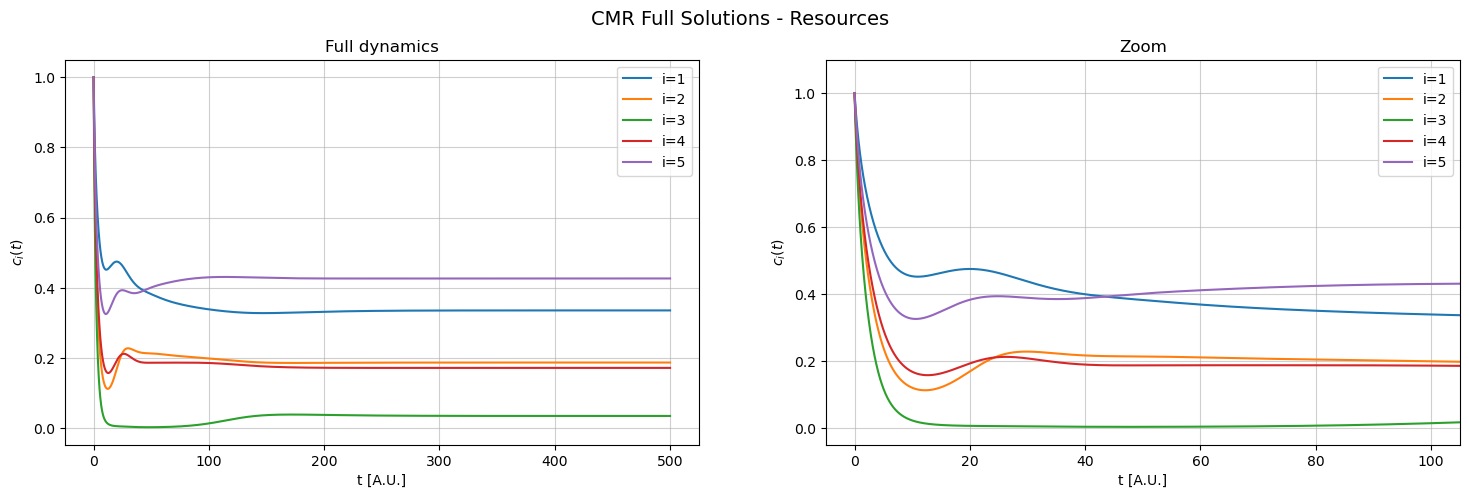

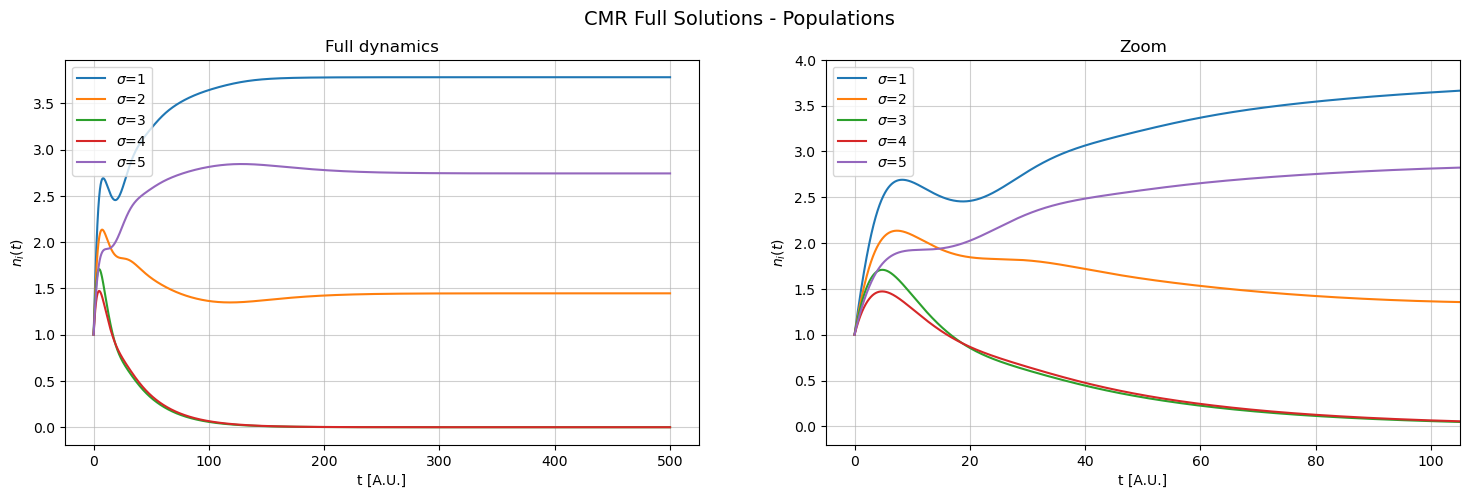

In [5]:
# Plots

c_xzoom=(-5,105)
c_yzoom=(-0.05,1.1)

n_xzoom=(-5,105)
n_yzoom=(-0.2,4)

sim_plotter(t, c, N, S, c_xzoom, c_yzoom, n_xzoom, n_yzoom, sol_type="CMR Full");

#### 1.1.2. Stationary solutions

As we can observe, both the populations and the resources reach a stationary state after some time transient.

At stationarity we have:
$$
\begin{cases}
\dot{n}_\sigma=0 \quad \sigma=1,...,S\\
\dot{c}_i=0  \quad i=1,...,R
\end{cases}
$$

so, excluding the trivial solutions $n_\sigma ^* =c_i^*=0 $, for our system we obtain:

$$
\begin{cases}
\sum_{i=1}^R v_i \alpha_{\sigma i} c_i^* = \delta_\sigma \\
c_i^*= \frac{K_i}{w} \left(w- \sum_{\sigma=1}^S n_\sigma \alpha_{\sigma i} \right) 
\end{cases}
$$

The first equation tells us that a stationarity the growth rate of each species is equal to the death rate, futhermore, because the first equation is actually a system fo $S$ equations in $R$ variables, we obrain a constrain on the total number of the species and the total number of the resources:

$$
\begin{cases}
R<S \implies \text{No solutions} \\
R \ge S \implies \text{Solutions}
\end{cases}
$$
that is satisfied for our system beacause $S=R=5$.

In order to verify if the stationary solutions of the simulation are consistent with the theoretical ones, a stationary time series for each species and resources have been extrapolated from the simulation. The time range selected is $[300,500]$.

Such data are than used to verify if the growth rate of the species at stationarity is actually equal to the death rate and if the number of resources at stationarity is equal to the value $c_i^*$ predicted by our model.

In [6]:
# Gettin stationarity states from the full simulation

cut=int(300/time_step)

stat_solutions_populations = pd.DataFrame()
stat_solutions_resources = pd.DataFrame()

stat_solutions_populations = pd.concat([stat_solutions_populations, pd.DataFrame(y[cut:, :S])], ignore_index=True)
stat_solutions_resources = pd.concat([stat_solutions_resources, pd.DataFrame(y[cut:, S:])], ignore_index=True)

col_names_pop=["sp 1","sp 2","sp 3","sp 4","sp 5"]
stat_solutions_populations.columns = col_names_pop

col_names_res=["res 1","res 2","res 3","res 4","res 5"]
stat_solutions_resources.columns = col_names_res


print("Length of the time series at stationary:",n.numerize(len(stat_solutions_populations["sp 1"])),"\n")
print(stat_solutions_populations.head(5),"\n")
print(stat_solutions_resources.head(5),"\n")

c_stat=c[cut:, :]       # resources at stationarity
N_stat=N[cut:, :]       # populations at stationarity

Length of the time series at stationary: 200K 

       sp 1      sp 2      sp 3      sp 4      sp 5
0  3.781684  1.445466  0.000074  0.000096  2.744721
1  3.781684  1.445466  0.000074  0.000096  2.744721
2  3.781684  1.445466  0.000074  0.000096  2.744721
3  3.781684  1.445466  0.000074  0.000096  2.744721
4  3.781684  1.445466  0.000074  0.000096  2.744720 

      res 1     res 2     res 3     res 4    res 5
0  0.335723  0.187542  0.035793  0.172307  0.42693
1  0.335723  0.187542  0.035793  0.172307  0.42693
2  0.335723  0.187542  0.035793  0.172307  0.42693
3  0.335723  0.187542  0.035793  0.172307  0.42693
4  0.335723  0.187542  0.035793  0.172307  0.42693 



In [7]:
# Testing analitiacl result over simulation data

stat_growth=[]
for i in range(len(c_stat)):
    stat_growth.append(growth_stationary(v,alpha,c_stat[i,:]))

stat_c=[]
for i in range(len(N_stat)):
    stat_c.append(c_star(w,K,alpha,N_stat[i,:]))

stat_growth=np.concatenate(stat_growth).reshape(-1,S)
stat_c=np.concatenate(stat_c).reshape(-1,S)

mean_growth_rate_stat=stat_growth.mean(0)
mean_growth_rate_stat_error=np.sqrt((mean_growth_rate_stat - d)**2)
growth_rate_results=pd.DataFrame({"":col_names_pop,"Mean Growth Rate": mean_growth_rate_stat,"Expected Growth Rate": d, "Error":mean_growth_rate_stat_error})


mean_resources_stat=stat_c.mean(0)
mean_resources_stat_error=np.sqrt((mean_resources_stat - np.array(stat_solutions_resources.mean()))**2)
resources_results=pd.DataFrame({"":col_names_res,"Mean Resource Number":np.array(stat_solutions_resources.mean()),\
    "c star":mean_resources_stat,"Error":mean_resources_stat_error})

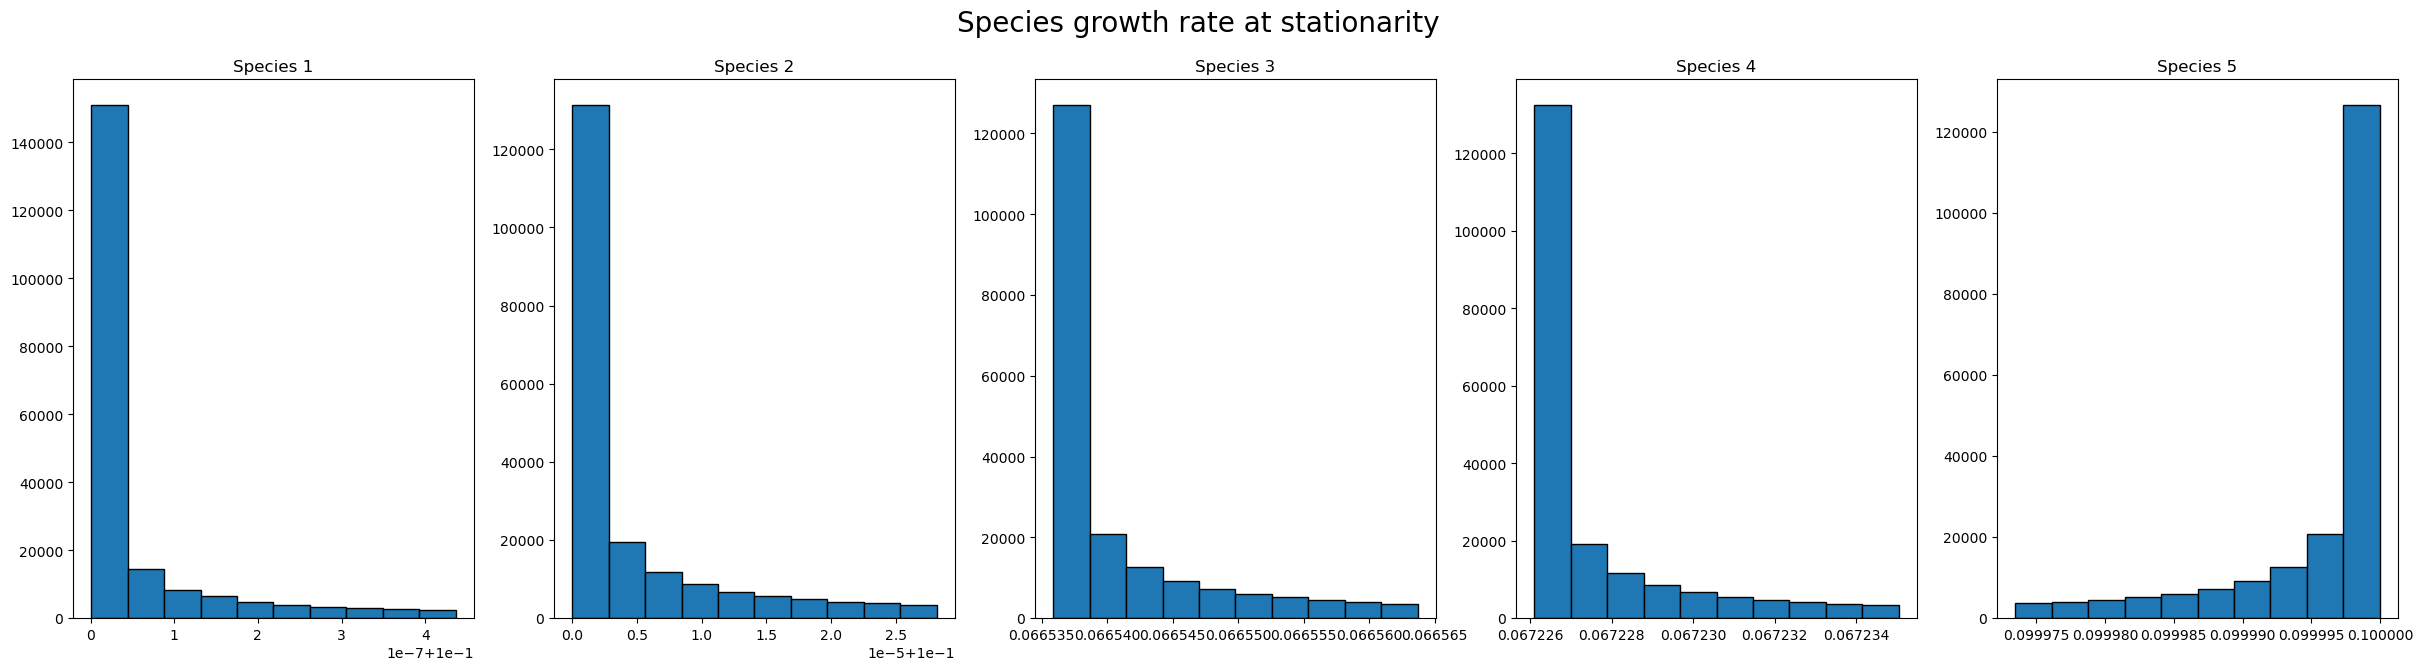

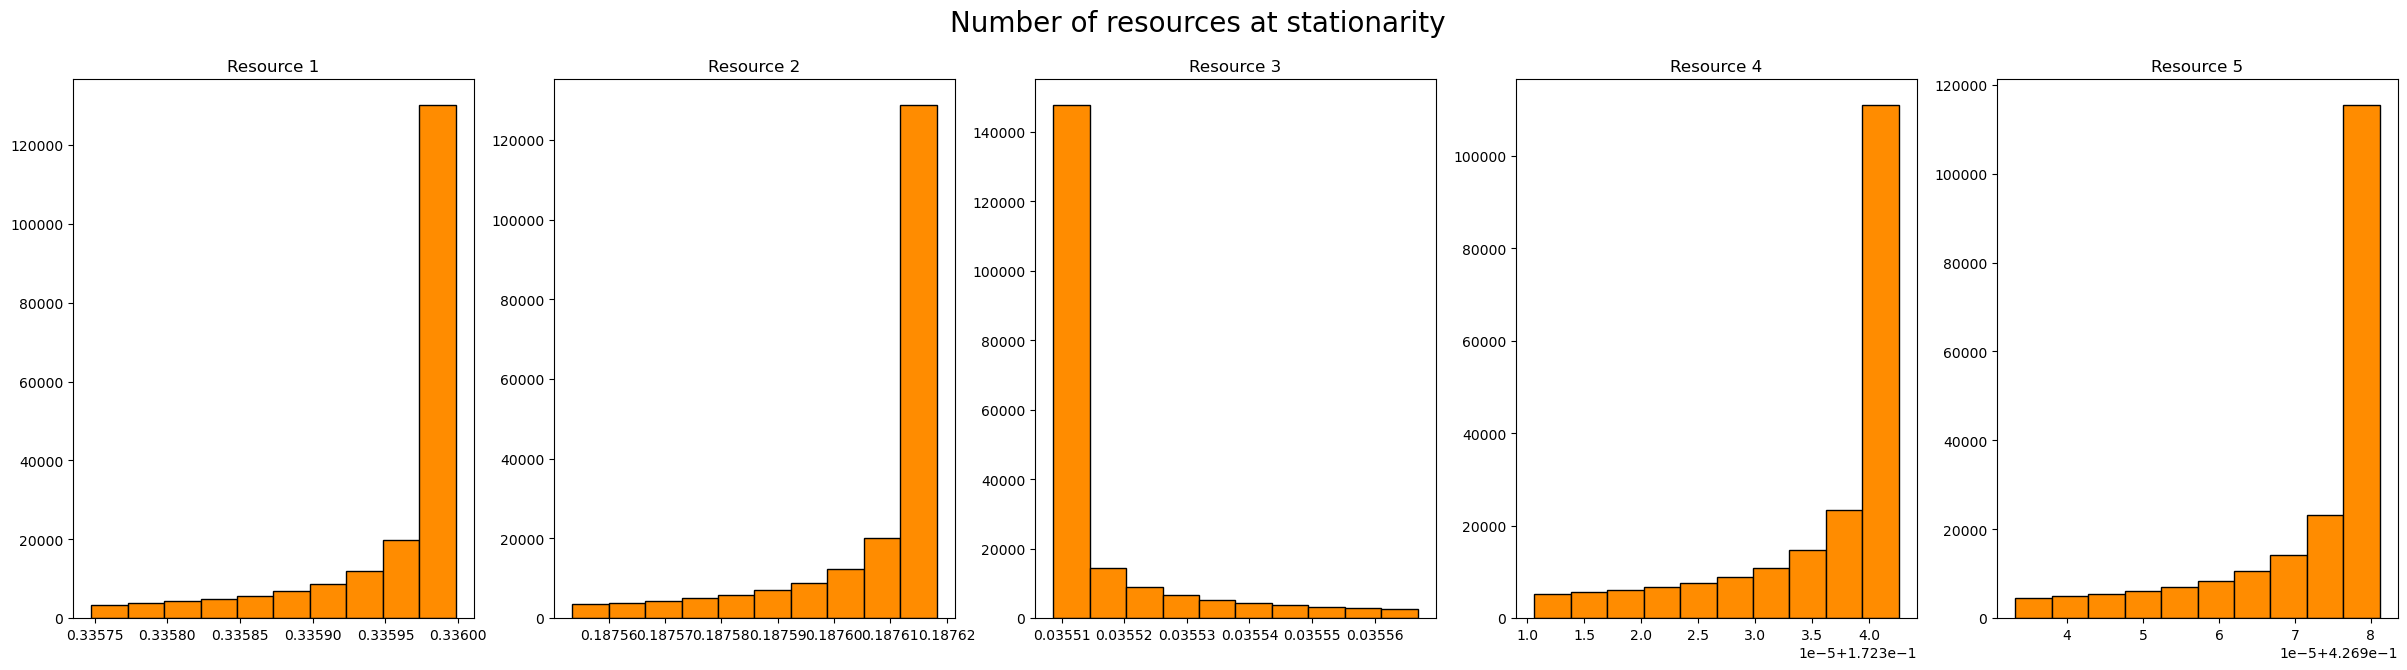

In [8]:
fig, ax = plt.subplots(1,5,figsize=(30,7))
fig.suptitle("Species growth rate at stationarity",fontsize=20)
for i in range(S):
    ax[i].set(title="Species {}".format(i+1))
    ax[i].hist(stat_growth[:,i],edgecolor="black")
   

fig, ax = plt.subplots(1,5,figsize=(30,7))
fig.suptitle("Number of resources at stationarity",fontsize=20)
for i in range(S):
    ax[i].set(title="Resource {}".format(i+1))
    ax[i].hist(stat_c[:,i],edgecolor="black",color="darkorange")

In [9]:
growth_rate_results

,,Mean Growth Rate,Expected Growth Rate,Error
0,sp 1,0.100000,0.1,4.796771e-08
1,sp 2,0.100004,0.1,4.239503e-06
2,sp 3,0.066540,0.1,3.345967e-02
3,sp 4,0.067227,0.1,3.277257e-02
4,sp 5,0.099996,0.1,4.285422e-06


In [10]:
resources_results

,,Mean Resource Number,c star,Error
0,res 1,0.335956,0.335960,4.099789e-06
1,res 2,0.187606,0.187608,2.042131e-06
2,res 3,0.035555,0.035515,3.974395e-05
3,res 4,0.172335,0.172336,1.035546e-06
4,res 5,0.426972,0.426972,5.950069e-07


The simulated data at stationarity seems to be consistent with the predictions of the stationary solutions of our model.

### 1.2. QSA solutions 

To get the quasi-stationary solutions for our system we impose that:

$$
\dot{c}_i=0 \quad \text{for} \quad c_i=c_i^*
$$

Excluding the trivial solution $c_i^*=0$, our model becomes:

$$
\begin{cases}
c_i^*= \frac{K_i}{w} \left(w- \sum_{\sigma=1}^S n_\sigma \alpha_{\sigma i} \right)  \qquad i=1,...,R \\
\dot{n}_\sigma=n_\sigma\left( \sum^R_{i=1}v_i \alpha_{\sigma i}c_i^*-\delta_\sigma\right) \qquad \sigma=1,...,S 
\end{cases}
$$

that is formally equivalent to a Generalized Lotka-Volterra (GLV):

$$
\dot{N}_i=N_i\left(a_i -\sum_{j=1}^S a_{ji}N_j \right)
$$

#### 1.2.1. QSA simulation (w=10)

For this simulation we set $w=10$, while all other parameters were left the same as those set for the previous simulation.

In [11]:
np.random.seed(42) # "the answer to life, the universe and everything"

# Parameters

S=5                                             # number of species
R=5                                             # number of resources
w=10

alpha=np.random.uniform(0,0.2,(S,R))            # metabolic strategies      
d=np.ones(S)*0.1                                # death rates
K=np.ones(R)                                    # resource-specific constants
v=np.ones(S)                                    # resource-biomass convertioms

N0=np.ones(S)                                   # initial population for each species
c0=np.ones(R)                                   # initial abundance for each resources
y0=np.concatenate([N0, c0])


# QSA Simulation

time_period=500
time_step=0.001
t=np.linspace(0,time_period,int(time_period/time_step))

y = odeint(CRM_QSA, y0, t, args=(v, alpha, w, K, d, S))
N_QSA = y[:, :S]
c_QSA = y[:, S:]

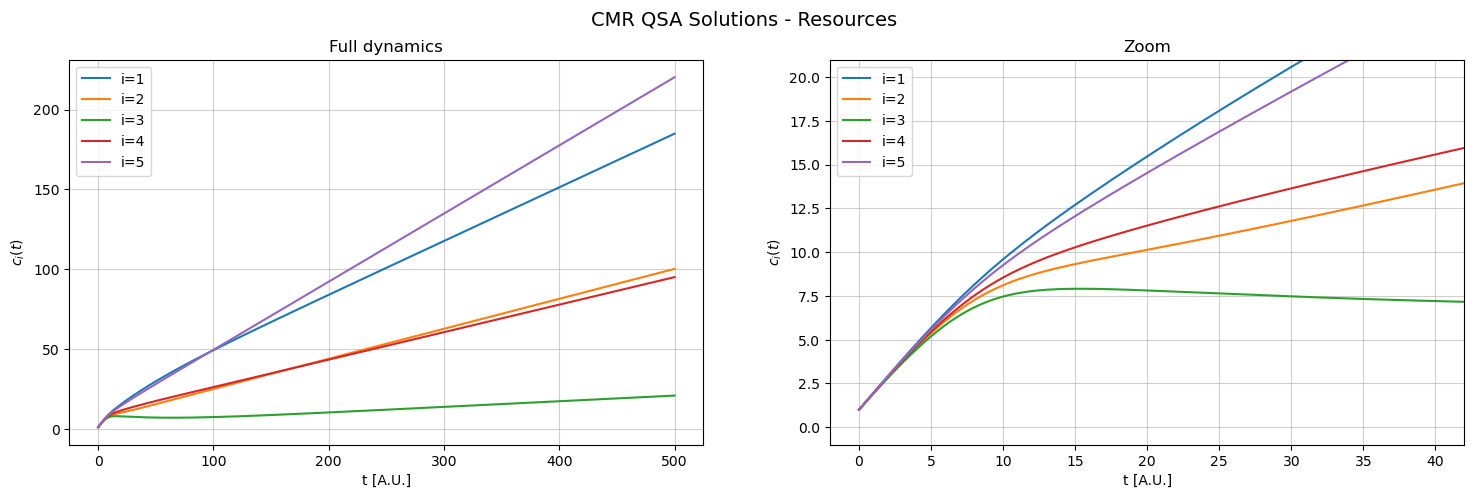

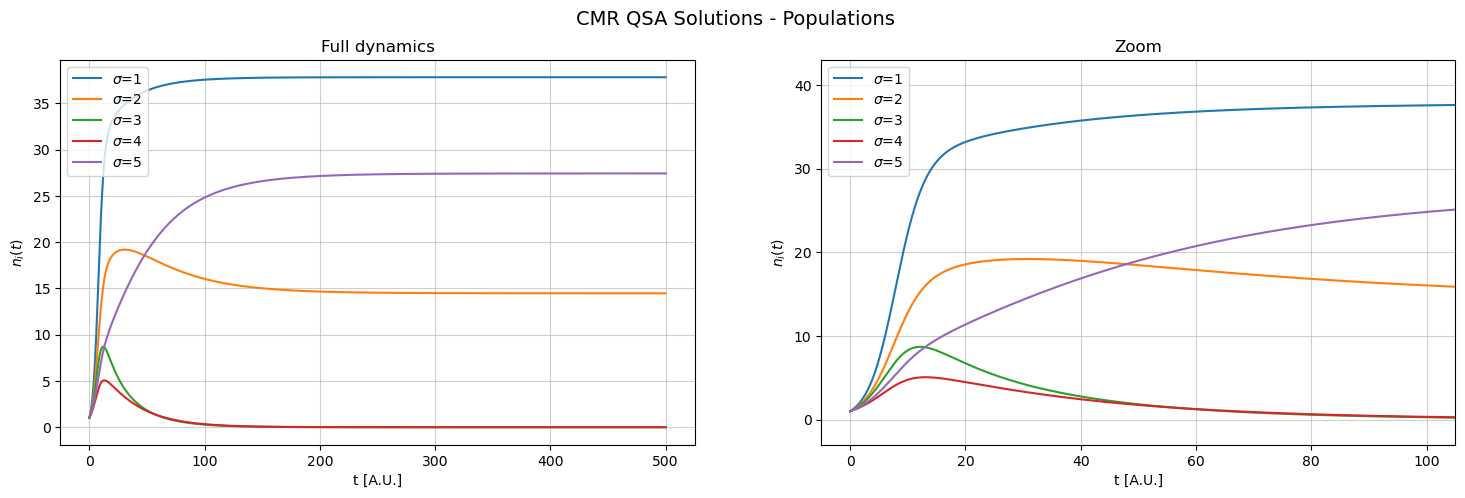

In [12]:
# QSA Plots

c_xzoom=(-2,42)
c_yzoom=(-1,21)

n_xzoom=(-5,105)
n_yzoom=(-3,43)

sim_plotter(t, c_QSA, N_QSA, S, c_xzoom, c_yzoom, n_xzoom, n_yzoom, sol_type="CMR QSA");

#### 1.2.2. QSA solutions vs full solutions

In [13]:
# Full Simulation

time_period=500
time_step=0.001
t=np.linspace(0,time_period,int(time_period/time_step))

y = odeint(CRM, y0, t, args=(v, alpha, w, K, d, S))
N_full = y[:, :S]
c_full = y[:, S:]

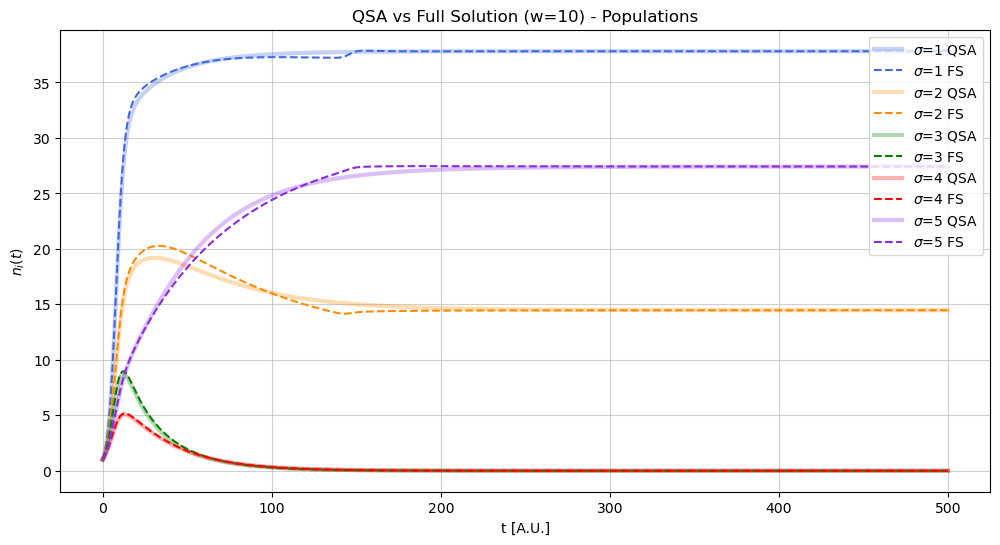

In [14]:
# QSA vs Full solutions plot

colors=["royalblue","darkorange","green","red","blueviolet"]

fig, ax = plt.subplots(figsize=(12,6))
ax.set(xlabel="t [A.U.]", ylabel="$n_i(t)$", title="QSA vs Full Solution (w=10) - Populations")
ax.grid(alpha=0.6)
for i in range(S):
    ax.plot(t,N_QSA[:,i],label="$\sigma$={} QSA".format(i+1),color=colors[i],alpha=0.3,lw=3)
    ax.plot(t,N_full[:,i],ls="dashed",label="$\sigma$={} FS".format(i+1),color=colors[i])
ax.legend(loc=1);

As expected, looking at the graph above, we can observe that the QSA approximates quite well the full solution of our system.

#### 1.2.3. Comparison between full CRM statistics and QSA CRM statistics at stationarity

In order to compare the full CRM statistics and the QSA CRM statistic at stationarity, we perform 50 simulations of both solutions changing for each realization the metabolic strategy matrix at random. 

In [15]:
# Control params

realizations=50

S=5
R=5
w=10
          
d=np.ones(S)*0.1                               
K=np.ones(R)                                    
v=np.ones(S)                                    

time_period=500
time_step=0.001
t=np.linspace(0,time_period,int(time_period/time_step))

cut=int(300/time_step)


# Generate statistics

full_statistics = pd.DataFrame()
QSA_statistics = pd.DataFrame()

for r in range(realizations):
    alpha=np.random.uniform(0,0.2,(S,R)) 
    N0=np.ones(S)                                   
    c0=np.ones(R)                                   
    y0=np.concatenate([N0, c0])

    y_full = odeint(CRM, y0, t, args=(v, alpha, w, K, d, S))
    y_QSA = odeint(CRM_QSA, y0, t, args=(v, alpha, w, K, d, S))

    full_statistics = pd.concat([full_statistics, pd.DataFrame(y_full[cut:, :S])], ignore_index=True)
    QSA_statistics = pd.concat([QSA_statistics, pd.DataFrame(y_QSA[cut:, :S])], ignore_index=True)

col_names=["sp 1","sp 2","sp 3","sp 4","sp 5"]

full_statistics.columns=col_names
QSA_statistics.columns=col_names

print("Length of the time series at stationarity:", n.numerize(len(full_statistics["sp 1"])),"\n")
print("Full statistics:\n", full_statistics.head(5),"\n")
print("QSA statistics:\n", QSA_statistics.head(5),"\n")

Length of the time series at stationarity: 10M 

Full statistics:
        sp 1       sp 2      sp 3      sp 4       sp 5
0  0.052727  23.081718  0.098321  0.036702  51.613388
1  0.052726  23.081718  0.098319  0.036702  51.613391
2  0.052725  23.081719  0.098318  0.036701  51.613394
3  0.052723  23.081720  0.098316  0.036700  51.613397
4  0.052722  23.081720  0.098314  0.036700  51.613400 

QSA statistics:
        sp 1       sp 2      sp 3      sp 4       sp 5
0  0.049137  22.987427  0.101248  0.026053  51.600004
1  0.049136  22.987428  0.101246  0.026053  51.600007
2  0.049135  22.987429  0.101244  0.026052  51.600010
3  0.049134  22.987429  0.101243  0.026052  51.600013
4  0.049133  22.987430  0.101241  0.026051  51.600015 



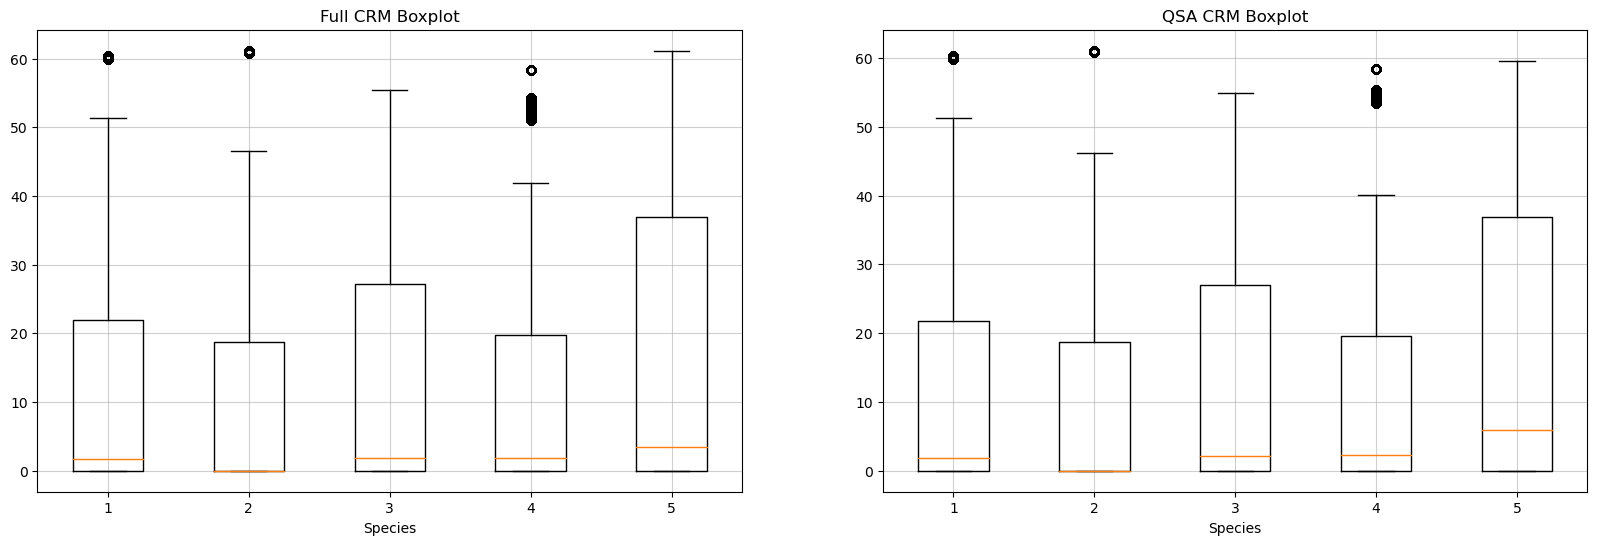

In [16]:
# Boxplots

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].set(title="Full CRM Boxplot",xlabel="Species")
ax[0].grid(alpha=0.6)
ax[0].boxplot(full_statistics)

ax[1].set(title="QSA CRM Boxplot",xlabel="Species")
ax[1].grid(alpha=0.6)
ax[1].boxplot(QSA_statistics);

As we can observe from the boxplot above, the QSA statistics is consistent with the full one at the stationarity.

### 1.3. QSA approximation for w=0.1

In [17]:
np.random.seed(42) # "the answer to life, the universe and everything"

# Parameters

S=5                                             # number of species
R=5                                             # number of resources
w=0.1

alpha=np.random.uniform(0,0.2,(S,R))            # metabolic strategies      
d=np.ones(S)*0.1                                # death rates
K=np.ones(R)                                    # resource-specific constants
v=np.ones(S)                                    # resource-biomass convertioms

N0=np.ones(S)                                   # initial population for each species
c0=np.ones(R)                                   # initial abundance for each resources
y0=np.concatenate([N0, c0])


# QSA Simulation

time_period=500
time_step=0.001
t=np.linspace(0,time_period,int(time_period/time_step))

y = odeint(CRM_QSA, y0, t, args=(v, alpha, w, K, d, S))
N_QSA = y[:, :S]
c_QSA = y[:, S:]

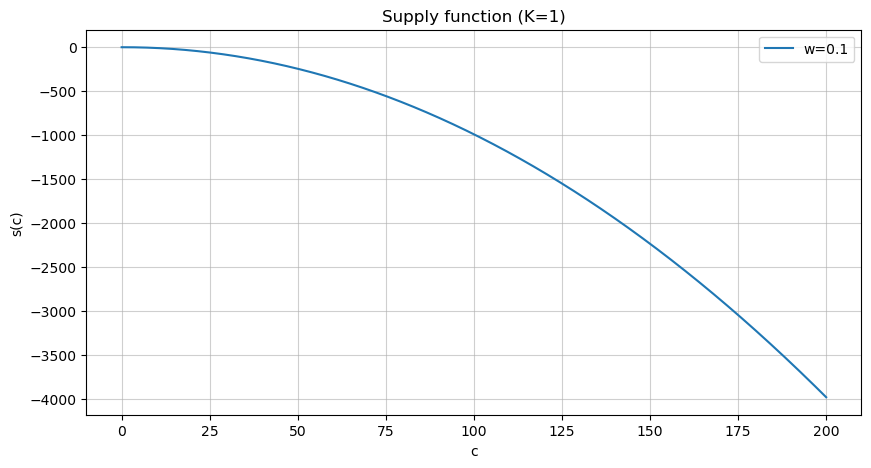

In [18]:
# Supply function

def supply(c, w, K):
    return w * c * (1 - c/K)


c=np.linspace(0,200,1000)
K=1
W=[0.1]

fig, ax= plt.subplots(figsize=(10,5))
ax.set(title="Supply function (K=1)",ylabel="s(c)",xlabel="c")
ax.grid(alpha=0.6)
for w in W:
    ax.plot(c,supply(c,w,K),label="w={}".format(w))
    ax.legend()

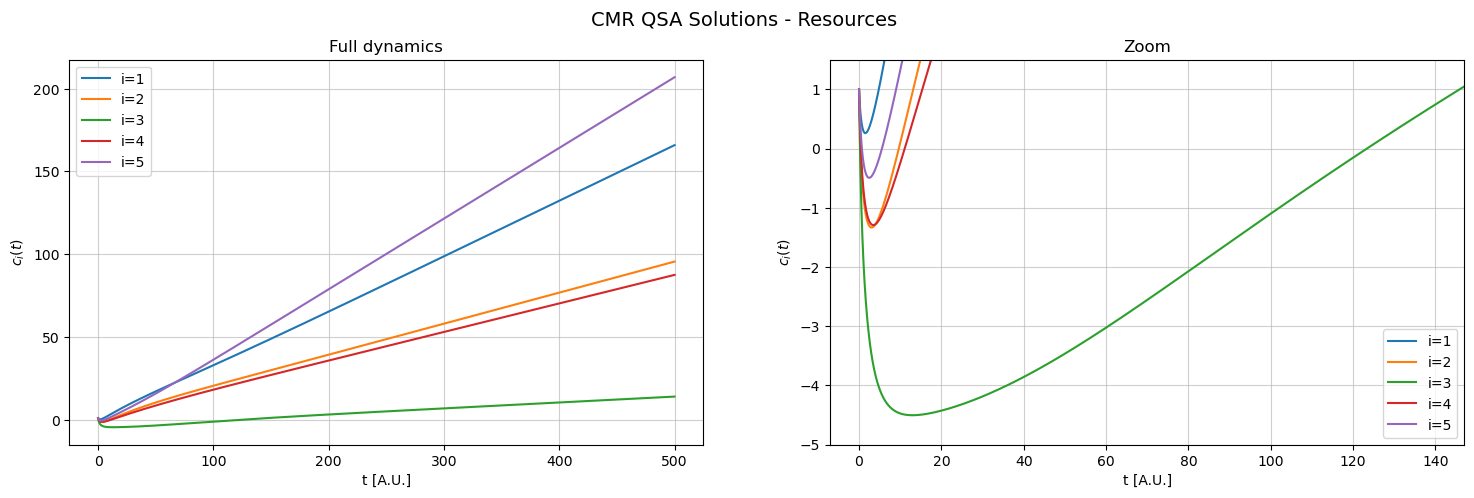

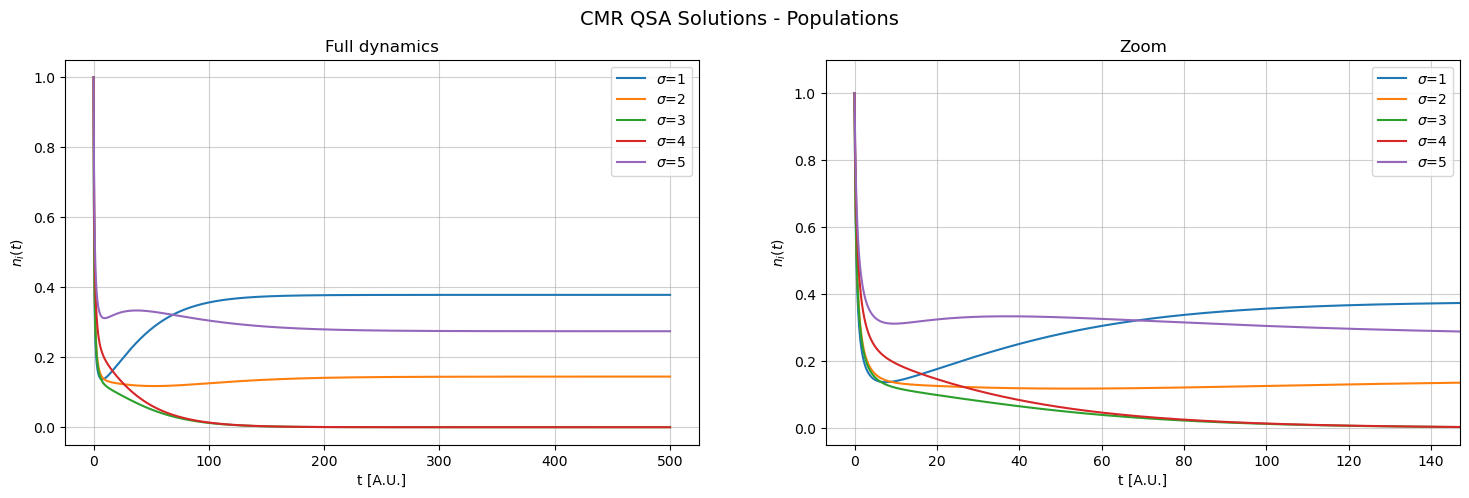

In [19]:
# QSA Plots

c_xzoom=(-7,147)
c_yzoom=(-5,1.5)

n_xzoom=(-7,147)
n_yzoom=(-0.05,1.1)

sim_plotter(t, c_QSA, N_QSA, S, c_xzoom, c_yzoom, n_xzoom, n_yzoom, sol_type="CMR QSA");

The simulation fails for $w=0.1$. As we can observe from the zoom in the Resources plot, under this parameters, we get negative resources for all $i$ exept for $i=1$. This behavor have no physical sense so we reject the simulation.